# Predict Future Sales 

In [1]:
import pandas as pd
import numpy as np
import gc
import itertools
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train     = pd.read_csv('sales_train_v2.csv')
items     = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops     = pd.read_csv('shops.csv')
test      = pd.read_csv('test.csv.gz')
test['date_block_num'] = 34
groupby_cols = ['date_block_num', 'shop_id', 'item_id']

In [2]:
#category
cat = items[['item_id', 'item_category_id']].drop_duplicates()
cat.set_index(['item_id'], inplace=True)
cat = cat.item_category_id
train['cat'] = train.item_id.map(cat)

#meta_category   games, gifts, work, etc.
item_cats['meta_cat'] = item_cats.item_category_name.apply(lambda x: x.split(' ')[0])
item_cats['meta_cat'] = pd.Categorical(item_cats.meta_cat).codes
item_cats.set_index(['item_category_id'], inplace=True)
meta_cat = item_cats.meta_cat
train['meta_cat'] = train.cat.map(meta_cat)

#city
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
train['city'] = train.shop_id.map(city)

#year
year = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append( pd.Series([2015], index=[34]) )

#month
month = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append( pd.Series([11], index=[34]) )

In [3]:
all_shops_items = []

for block_num in train['date_block_num'].unique():
    unique_shops = train[ train['date_block_num']==block_num ]['shop_id'].unique()
    unique_items = train[ train['date_block_num']==block_num ]['item_id'].unique()
    all_shops_items.append( np.array( list( itertools.product([block_num], unique_shops, unique_items) ), dtype='int32' ) )

df = pd.DataFrame( np.vstack( all_shops_items ), columns=groupby_cols , dtype='int32')
df = df.append(test )

df['ID'] = df.ID.fillna(-1).astype('int32')

df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['cat'] = df.item_id.map(cat)
df['meta_cat'] = df.cat.map(meta_cat)
df['city'] = df.shop_id.map(city)
train['cat'] = train.item_id.map(cat)

In [4]:
df.sample(20)

,ID,date_block_num,item_id,shop_id,year,month,cat,meta_cat,city
9510958,-1,27,7932,3,2015,4,7,1,1
2980170,-1,7,14819,15,2013,8,40,7,9
824101,-1,2,21739,31,2013,3,40,7,13
1584772,-1,4,13605,19,2013,5,57,9,12
9655592,-1,28,15405,31,2015,5,63,10,13
9809863,-1,29,505,31,2015,6,31,5,13
10309457,-1,31,3424,58,2015,8,19,5,29
3009851,-1,7,9811,12,2013,8,40,7,7
7403689,-1,20,14197,7,2014,9,31,5,4
8779659,-1,25,18116,33,2015,2,40,7,14


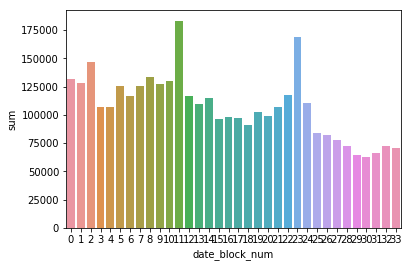

In [6]:
gb = train.groupby(by=['date_block_num'], as_index=False).agg({ 'item_cnt_day': ['sum']})
sns.barplot(x=gb['date_block_num'], y=gb['item_cnt_day']['sum'])

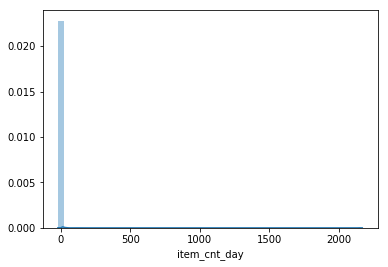

In [6]:
sns.distplot(train['item_cnt_day'])

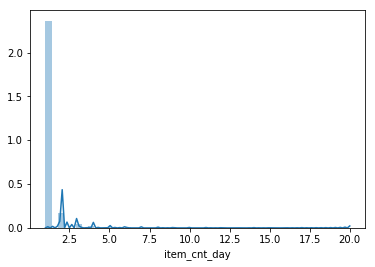

In [8]:
sns.distplot( train[ train['item_cnt_day'] > 0 ]['item_cnt_day'].clip(0, 20) )

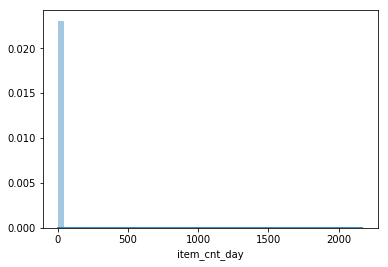

In [8]:
sns.distplot( train[ train['item_cnt_day'] > 0 ]['item_cnt_day'] )

In [9]:
gb = train.groupby(by=groupby_cols, as_index=False).agg({ 'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target'}, inplace=True)
df = pd.merge(df, gb, how='left', on=groupby_cols)

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_item'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_shop'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

gb = train.groupby( by=['date_block_num', 'cat'], as_index=False).agg({ 'item_cnt_day': ['sum'] })
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_cat'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'cat'])

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean':'target_price_mean', 'item_price_max':'target_price_max'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

In [10]:
gb.sample(20)

,date_block_num,item_id,target_price_mean,target_price_max
165053,21,19631,149.000000,149.0
161519,21,7332,199.000000,199.0
110055,13,12817,149.000000,149.0
96226,11,16353,249.000000,249.0
10765,1,8042,733.800000,948.0
224416,32,4389,2598.833333,2599.0
182909,24,15206,249.000000,249.0
146186,18,19126,369.200000,399.0
22350,2,16245,748.958333,749.0
50943,6,4373,1684.303571,1699.0


In [11]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype("int32")

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in minimum
  


In [16]:
df['target_price_mean2'] = np.minimum(df['target_price_mean'], df['target_price_mean'])

In [19]:
df['target_price_mean2']-df['target_price_mean'].head(20)

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
           ... 
11128020    NaN
11128021    NaN
11128022    NaN
11128023    NaN
11128024    NaN
11128025    NaN
11128026    NaN
11128027    NaN
11128028    NaN
11128029    NaN
11128030    NaN
11128031    NaN
11128032    NaN
11128033    NaN
11128034    NaN
11128035    NaN
11128036    NaN
11128037    NaN
11128038    NaN
11128039    NaN
11128040    NaN
11128041    NaN
11128042    NaN
11128043    NaN
11128044    NaN
11128045    NaN
11128046    NaN
11128047    NaN
11128048    NaN
11128049    NaN
Length: 11128050, dtype:

In [15]:
df['target_price_mean'].head(20)

0      999.000000
1      899.000000
2     1709.050000
3     1098.850000
4      327.600000
5      549.000000
6      284.333333
7      299.000000
8      392.986538
9      254.200000
10     285.200000
11     261.896552
12    1613.875000
13    1708.950000
14     299.000000
15     286.254167
16    1649.000000
17    1699.000000
18     882.031250
19     145.562500
Name: target_price_mean, dtype: float64

In [20]:
%%time
for enc_cols in [['shop_id', 'cat'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:
    
    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    df[col] = np.nan
    df[col2] = np.nan
    
    print(col, col2)
    
    for d in tqdm_notebook(df.date_block_num.unique()):
        

        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']
        
        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']

enc_shop_id_cat enc_max_shop_id_cat


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


enc_shop_id_item_id enc_max_shop_id_item_id


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


enc_shop_id enc_max_shop_id


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


enc_item_id enc_max_item_id


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


Wall time: 5min 53s


In [21]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float32_cols = [c for c in df if df[c].dtype == "float64"]
    int32_cols = [c for c in df if df[c].dtype in ["int64", "int16", "int8"] ]
            
    # Downcast
    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols]   = df[int32_cols].astype(np.int32)
        
    return df

In [22]:
df.fillna(0, inplace=True)
df = downcast_dtypes(df)

In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import gc
from time import sleep

groupby_cols = ['date_block_num', 'shop_id', 'item_id']
shift_range = [1, 2, 3, 4, 5, 12]

In [24]:
%%time

shifted_columns = [c for c in df if 'target' in c]
print(shifted_columns)


for shift in tqdm_notebook(shift_range):
    
    
    shifted_data = df[groupby_cols + shifted_columns].copy()
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in shifted_columns else x
    shifted_data = shifted_data.rename(columns=foo)
    
    
    df = pd.merge(df, shifted_data, how='left', on=groupby_cols).fillna(0)
    df = downcast_dtypes(df)

    del shifted_data
    gc.collect()
    sleep(1)

['target', 'target_item', 'target_shop', 'target_cat', 'target_price_mean', 'target_price_max', 'target_zero', 'target_price_mean2']


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


Wall time: 1min 47s


In [25]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1']*2 - df['target_lag_2']

df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2'])*2 - df['target_lag_3'] - df['target_lag_4']

df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']

In [26]:
df = downcast_dtypes(df)
df.to_pickle("df.pkl")

In [27]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score, roc_curve, roc_auc_score
import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [28]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['ID']
features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34

train, val = train_test_split(df[f0], test_size=0.2, stratify=df[f0]['target'])
test = df[f1]

In [ ]:
del df
gc.collect()

In [31]:
Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

In [30]:
del df
gc.collect()

125

In [23]:
%%time

xgb_params = {'booster': 'gbtree',
          'eta': .1,
          'min_child_weight': 100,
          'max_depth': 6,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'silent': False,
          'nthread': 8}

model = xgb.train(xgb_params, Train, 1000, [(Train, 'Train'), (Val, 'Val')], early_stopping_rounds=10, verbose_eval=1 )

[0]	Train-rmse:1.18913	Val-rmse:1.18896
Multiple eval metrics have been passed: 'Val-rmse' will be used for early stopping.

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Train-rmse:1.14699	Val-rmse:1.1467
[2]	Train-rmse:1.11109	Val-rmse:1.11073
[3]	Train-rmse:1.08091	Val-rmse:1.08064
[4]	Train-rmse:1.05491	Val-rmse:1.05465
[5]	Train-rmse:1.0335	Val-rmse:1.03327
[6]	Train-rmse:1.01491	Val-rmse:1.01469
[7]	Train-rmse:0.999004	Val-rmse:0.998775
[8]	Train-rmse:0.985893	Val-rmse:0.985731
[9]	Train-rmse:0.974862	Val-rmse:0.974777
[10]	Train-rmse:0.965402	Val-rmse:0.965413
[11]	Train-rmse:0.957533	Val-rmse:0.9576
[12]	Train-rmse:0.950589	Val-rmse:0.950685
[13]	Train-rmse:0.94466	Val-rmse:0.944899
[14]	Train-rmse:0.939619	Val-rmse:0.939953
[15]	Train-rmse:0.935179	Val-rmse:0.935581
[16]	Train-rmse:0.931412	Val-rmse:0.931898
[17]	Train-rmse:0.928184	Val-rmse:0.92868
[18]	Train-rmse:0.925132	Val-rmse:0.925698
[19]	Train-rmse:0.922471	Val-rmse:0.923096
[20]	Train-rmse:0.920226	Val-

[187]	Train-rmse:0.865905	Val-rmse:0.871347
[188]	Train-rmse:0.865677	Val-rmse:0.871131
[189]	Train-rmse:0.865375	Val-rmse:0.870843
[190]	Train-rmse:0.865228	Val-rmse:0.870748
[191]	Train-rmse:0.865046	Val-rmse:0.870585
[192]	Train-rmse:0.865039	Val-rmse:0.87058
[193]	Train-rmse:0.865027	Val-rmse:0.87058
[194]	Train-rmse:0.864985	Val-rmse:0.870547
[195]	Train-rmse:0.864778	Val-rmse:0.870355
[196]	Train-rmse:0.864612	Val-rmse:0.870197
[197]	Train-rmse:0.864445	Val-rmse:0.870014
[198]	Train-rmse:0.86413	Val-rmse:0.869729
[199]	Train-rmse:0.864019	Val-rmse:0.869664
[200]	Train-rmse:0.863814	Val-rmse:0.869477
[201]	Train-rmse:0.862967	Val-rmse:0.868627
[202]	Train-rmse:0.862698	Val-rmse:0.868397
[203]	Train-rmse:0.8626	Val-rmse:0.868356
[204]	Train-rmse:0.86233	Val-rmse:0.868101
[205]	Train-rmse:0.862216	Val-rmse:0.868005
[206]	Train-rmse:0.861982	Val-rmse:0.867812
[207]	Train-rmse:0.861943	Val-rmse:0.867789
[208]	Train-rmse:0.861807	Val-rmse:0.867673
[209]	Train-rmse:0.861667	Val-rmse:0.8

[375]	Train-rmse:0.846144	Val-rmse:0.855191
[376]	Train-rmse:0.84605	Val-rmse:0.855112
[377]	Train-rmse:0.845996	Val-rmse:0.855083
[378]	Train-rmse:0.845938	Val-rmse:0.855068
[379]	Train-rmse:0.845514	Val-rmse:0.854654
[380]	Train-rmse:0.84548	Val-rmse:0.854643
[381]	Train-rmse:0.845191	Val-rmse:0.854339
[382]	Train-rmse:0.84484	Val-rmse:0.853995
[383]	Train-rmse:0.844801	Val-rmse:0.85397
[384]	Train-rmse:0.844779	Val-rmse:0.853964
[385]	Train-rmse:0.844722	Val-rmse:0.853929
[386]	Train-rmse:0.844668	Val-rmse:0.853899
[387]	Train-rmse:0.844567	Val-rmse:0.853809
[388]	Train-rmse:0.844344	Val-rmse:0.85361
[389]	Train-rmse:0.844245	Val-rmse:0.853531
[390]	Train-rmse:0.844216	Val-rmse:0.853497
[391]	Train-rmse:0.844137	Val-rmse:0.853459
[392]	Train-rmse:0.844096	Val-rmse:0.853433
[393]	Train-rmse:0.84405	Val-rmse:0.85342
[394]	Train-rmse:0.844007	Val-rmse:0.853399
[395]	Train-rmse:0.843914	Val-rmse:0.853356
[396]	Train-rmse:0.843881	Val-rmse:0.853343
[397]	Train-rmse:0.843729	Val-rmse:0.85

[563]	Train-rmse:0.832518	Val-rmse:0.84519
[564]	Train-rmse:0.832426	Val-rmse:0.845129
[565]	Train-rmse:0.83239	Val-rmse:0.845115
[566]	Train-rmse:0.832354	Val-rmse:0.845112
[567]	Train-rmse:0.832321	Val-rmse:0.845109
[568]	Train-rmse:0.83217	Val-rmse:0.84496
[569]	Train-rmse:0.832047	Val-rmse:0.84484
[570]	Train-rmse:0.831949	Val-rmse:0.844763
[571]	Train-rmse:0.831914	Val-rmse:0.844769
[572]	Train-rmse:0.831861	Val-rmse:0.84474
[573]	Train-rmse:0.831843	Val-rmse:0.844737
[574]	Train-rmse:0.83184	Val-rmse:0.844736
[575]	Train-rmse:0.831741	Val-rmse:0.844637
[576]	Train-rmse:0.831674	Val-rmse:0.844607
[577]	Train-rmse:0.831612	Val-rmse:0.84458
[578]	Train-rmse:0.83159	Val-rmse:0.84457
[579]	Train-rmse:0.831542	Val-rmse:0.844524
[580]	Train-rmse:0.831509	Val-rmse:0.844504
[581]	Train-rmse:0.831489	Val-rmse:0.844503
[582]	Train-rmse:0.831447	Val-rmse:0.844473
[583]	Train-rmse:0.831425	Val-rmse:0.844457
[584]	Train-rmse:0.831307	Val-rmse:0.844337
[585]	Train-rmse:0.831267	Val-rmse:0.84431

[751]	Train-rmse:0.822187	Val-rmse:0.837753
[752]	Train-rmse:0.822043	Val-rmse:0.837602
[753]	Train-rmse:0.821972	Val-rmse:0.837557
[754]	Train-rmse:0.821945	Val-rmse:0.837549
[755]	Train-rmse:0.821818	Val-rmse:0.837412
[756]	Train-rmse:0.821757	Val-rmse:0.837359
[757]	Train-rmse:0.821674	Val-rmse:0.837282
[758]	Train-rmse:0.821632	Val-rmse:0.837273
[759]	Train-rmse:0.82141	Val-rmse:0.837028
[760]	Train-rmse:0.821393	Val-rmse:0.837022
[761]	Train-rmse:0.821327	Val-rmse:0.836974
[762]	Train-rmse:0.821297	Val-rmse:0.836954
[763]	Train-rmse:0.821266	Val-rmse:0.836945
[764]	Train-rmse:0.821248	Val-rmse:0.836937
[765]	Train-rmse:0.821163	Val-rmse:0.836878
[766]	Train-rmse:0.821139	Val-rmse:0.836878
[767]	Train-rmse:0.821117	Val-rmse:0.83688
[768]	Train-rmse:0.821071	Val-rmse:0.836847
[769]	Train-rmse:0.820994	Val-rmse:0.836798
[770]	Train-rmse:0.820981	Val-rmse:0.836788
[771]	Train-rmse:0.820828	Val-rmse:0.836603
[772]	Train-rmse:0.82079	Val-rmse:0.836599
[773]	Train-rmse:0.820766	Val-rmse:

[939]	Train-rmse:0.814659	Val-rmse:0.832683
[940]	Train-rmse:0.81464	Val-rmse:0.832677
[941]	Train-rmse:0.814613	Val-rmse:0.832668
[942]	Train-rmse:0.814584	Val-rmse:0.832667
[943]	Train-rmse:0.814567	Val-rmse:0.832654
[944]	Train-rmse:0.814557	Val-rmse:0.832656
[945]	Train-rmse:0.814498	Val-rmse:0.832618
[946]	Train-rmse:0.814425	Val-rmse:0.83257
[947]	Train-rmse:0.81439	Val-rmse:0.832552
[948]	Train-rmse:0.814341	Val-rmse:0.83254
[949]	Train-rmse:0.814306	Val-rmse:0.832514
[950]	Train-rmse:0.81425	Val-rmse:0.832476
[951]	Train-rmse:0.814225	Val-rmse:0.832473
[952]	Train-rmse:0.814189	Val-rmse:0.832468
[953]	Train-rmse:0.814164	Val-rmse:0.832445
[954]	Train-rmse:0.814144	Val-rmse:0.832443
[955]	Train-rmse:0.814084	Val-rmse:0.832397
[956]	Train-rmse:0.814047	Val-rmse:0.832374
[957]	Train-rmse:0.814017	Val-rmse:0.832353
[958]	Train-rmse:0.813935	Val-rmse:0.832279
[959]	Train-rmse:0.813916	Val-rmse:0.832272
[960]	Train-rmse:0.813888	Val-rmse:0.832256
[961]	Train-rmse:0.813861	Val-rmse:0.

In [24]:
test['item_cnt_month'] = model.predict(Test).clip(0, 20)
test[['ID', 'item_cnt_month']].sort_values('ID').to_csv('boost_pred.csv', index=False)

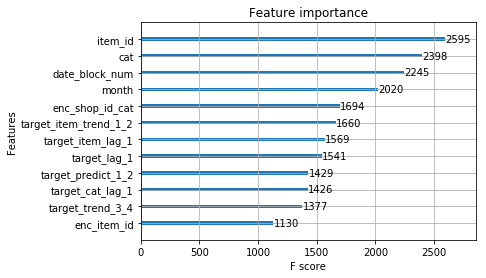

In [25]:
xgb.plot_importance(booster=model, max_num_features=12)

In [28]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import numpy as np
import gc

In [33]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['item_id', 'shop_id']
drop_columns += ['ID']

features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34


train, val = train_test_split(df[f0], test_size=0.1, stratify=df[f0]['target'])
test = df[f1]

Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

del df
gc.collect()

MemoryError: 

In [31]:
def objective(params):
    
    params = {
        'booster': 'gbtree',
        'silent': True,
        'nthread': 8,
        
        'eta': "{:.3f}".format(params['eta']),
        'gamma': "{:.3f}".format(params['gamma']),
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'subsample': "{:.3f}".format(params['subsample']),        
        'colsample_bytree': "{:.3f}".format(params['colsample_bytree']),
        'lambda': "{:.3f}".format(params['lambda']),
        'alpha': "{:.3f}".format(params['alpha']),
          
        'objective': 'reg:linear',
        'eval_metric': 'rmse'
        
    }

    watchlist = [(Train, 'Train'), (Val, 'Val')]
    
    model = xgb.train(
        params,
        Train,
        25,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=100 )
    
    

    y_pred = model.predict(Val)
    score = np.sqrt( mean_squared_error(val['target'].clip(0, 20), y_pred.clip(0, 20)))
    
    #score = 1
                    
    print("score {:.3f} params {}".format(score, params))
    return score

space = {
    'eta': hp.uniform('learning_rate', 0.01, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),'gamma': hp.uniform('gamma', 0.0, 0.3),
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'min_child_weight': hp.uniform('min_child_weight', 1, 200),
    'subsample': hp.uniform('subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'lambda': hp.uniform('lambda', 0.0, 0.3),
    'alpha': hp.uniform('alpha', 0.0, 0.3),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=3)

print(best)

TypeError: 'generator' object is not subscriptable